<a href="https://colab.research.google.com/github/philcd89/Mickey_Ninjas/blob/main/Steinmetz_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Steinmetz SPIKING data

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import math

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Loading Steinmetz LFP data

In [ ]:
#@title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading
import numpy as np

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = dat_LFP[11]
print(dat.keys())
dat = dat_WAV[11]
print(dat.keys())
dat = dat_ST[11]
print(dat.keys())

`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




# Exploration playground (anyone)

In [ ]:
import matplotlib.pyplot as plt

for area in range(len(dat_LFP[11]['lfp'])):
  plt.plot(dat_LFP[11]['lfp'][area][0], 'K', alpha = 0.2)

plt.show()

NameError: ignored

# Visualize Neuron spiking histograms for each Session

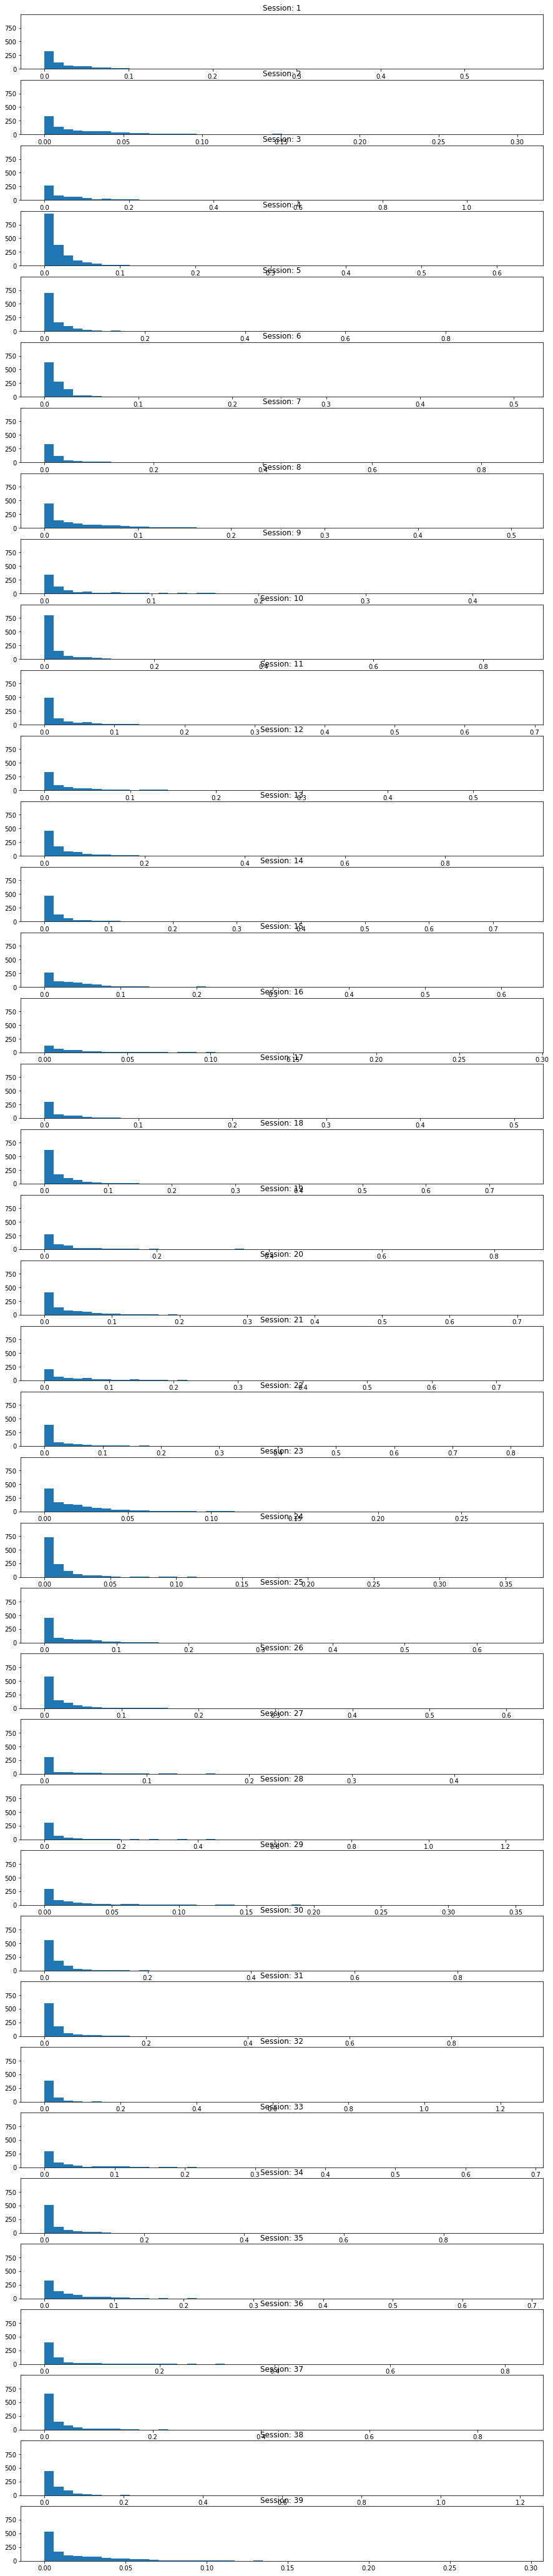

In [ ]:
#Load a debugger
from IPython.core.debugger import set_trace
import math as m
import matplotlib.pyplot as plt

def get_neuron_histograms(data = alldat, session = list(np.arange(0, 39, 1))):

  fig, ax = plt.subplots(m.ceil(len(session)), sharex=False, sharey=True)

  for i in session:
    dat = data[i]

    spikes = dat["spks"]

    #print(spikes.shape)

    spikes_agg_nrns = np.mean(spikes, axis = 2)
    spikes_agg_nrns_smpl = np.mean(spikes_agg_nrns, axis = 1)


    ax[i].hist(spikes_agg_nrns_smpl, bins = 50)
    #plt.xlabel("Mean firing rate over trials and samples")
    #plt.ylabel("number of neurons")
    ax[i].title.set_text('Session: ' + str(i+1))

    #set_trace()
  #plt.set_xlabel('Mean firing rate over trials and samples')
  #plt.set_ylabel('# neurons')
  fig.set_figheight(75)
  fig.set_figwidth(15)
  plt.show()

get_neuron_histograms()
  



# Time window code (Ronan)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


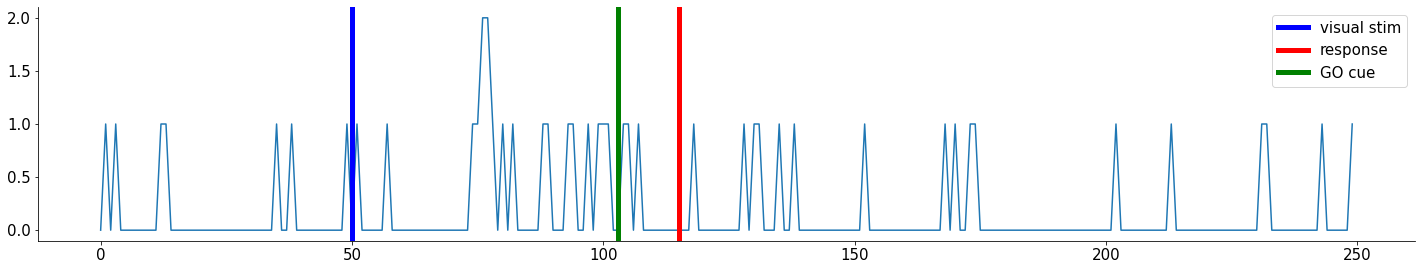

In [4]:
# function to loop through trial data and create 2 x 1 array describing the time
# point at which visual stimulus was displayed and a second event within the 
# trial (e.g. response, go cue onset). Option to keep units in seconds or change
# to 10ms time bin format used by spike data

def time_window_generator(start_window_variable, end_window_variable, spike_rate_format=True):
  '''
  Creates a time window on visual stim onset to later trial event

  Args:
    start_window_variable (float)               : fixed value for visual stim onset (s)
    end_window_variable (numpy array of floats) : array of second event times per trial (s)
    spike_rate_format (boolean)                 : boolean whether to calculate in 10ms bins
  
  Returns:
    numpy array of floats

  '''
  number_trials = len(end_window_variable) #loop through number of trials per session
  start_window = start_window_variable
  time_window = np.zeros((number_trials, 2)) #initialize time_window variable
  
  
  for trial in range(number_trials):
    time_window[trial] = np.array([start_window, end_window_variable[trial]]) * 100
    
  if spike_rate_format:
    time_window = np.round(time_window)


  return time_window

for session in range(len(alldat)):
  
  dat = alldat[session]
  dat['stim_response_time_window'] = time_window_generator(dat['stim_onset'], dat['response_time'])
  dat['stim_gocue_time_window'] = time_window_generator(dat['stim_onset'], dat['gocue'])
  

# example plot of time windows on single trial
plt.plot(alldat[0]['spks'][670][0])
plt.axvline(alldat[0]['stim_response_time_window'][0][0], color='blue', linewidth=5, label = 'visual stim')
plt.axvline(alldat[0]['stim_response_time_window'][0][1], color='red', linewidth=5, label='response')
plt.axvline(alldat[0]['stim_gocue_time_window'][0][1], color='green', linewidth=5, label='GO cue')
plt.legend()








# Accuracy Analysis (Phil)

Defining a function to compute accuracy analysis



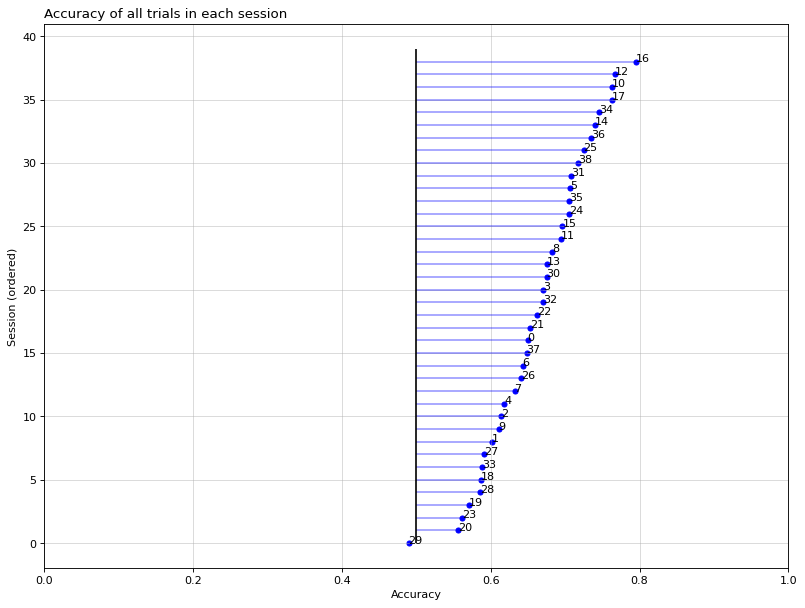

In [ ]:

#Load a debugger
from IPython.core.debugger import set_trace

import numpy as np

# Loading steinmetz data so that we don't have to download it every time.
fname = ["steinmetz_part1.npz", "steinmetz_part2.npz", "steinmetz_part3.npz"]
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

def compute_accuracy(data = alldat, session = list(np.arange(0, 39, 1))):
    """ 
    arguments:
    session: a list of session numbers to evaluate.  Default is all session in dat.
    
    output:
    accuracy: a session-length np.array of n-trial length arrays listing correct = 1, incorrect = 0
    accuracy_pct: a percentage score of correct vs. incorrect trials
    accuracy_move: a session-length np.array of arrays where movement was required
    accuracy_pct_move: a percentage score of correct vs. incorrect trials when movement was required
    indMove: index of trials where movement was supposed to happen within session
    """
    accuracy_all = []
    accuracy_move_all = []
    accuracy_bool_all = []
    accuracy_bool_move_all = []
    indMove_all = []
    
    for i, run in enumerate(session):
        # get relevant data
        
        #set_trace()
        response = data[i]['response'] # right - nogo - left (-1, 0, 1)
        vis_right = data[i]['contrast_right'] # 0 - low - high
        vis_left = data[i]['contrast_left'] # 0 - low - high

        #initialize empty boolean accuracy object
        accuracy_bool = np.zeros(len(response))

        # the following are the correct responses:
        # if vis_left > vis_right : response >0
        # if vis_left < vis_right : response <0
        # if vis_left = vis_right : response =0
        # trials below red line are incorrect
        is_correct = np.sign(response)==np.sign(vis_left-vis_right)
        accuracy_bool[is_correct] = 1
        accuracy = np.sum(accuracy_bool)/len(accuracy_bool)

        # Compute accuracy for only movement trials
        indMove = np.logical_or(vis_right > vis_left, vis_left > vis_right)

        # create vectors only of movement trials
        response_move = response[indMove]
        vis_right_move = vis_right[indMove]
        vis_left_move = vis_left[indMove]

        # compute accuracy only for movement trials
        accuracy_bool_move = np.zeros(len(response_move))

        is_correct_move = np.sign(response_move)==np.sign(vis_left_move - vis_right_move)
        accuracy_bool_move[is_correct_move] = 1
        accuracy_move = np.sum(accuracy_bool_move)/len(accuracy_bool_move)

        #set_trace()
        accuracy_all.append(accuracy)
        accuracy_move_all.append(accuracy_move)
        accuracy_bool_all.append(accuracy_bool)
        accuracy_bool_move_all.append(accuracy_bool_move)
        indMove_all.append(indMove)
        
    return([accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove])

accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove = compute_accuracy()

### Accuracy Plots

#Accuracy for each session

import pandas as pd
import matplotlib.pyplot as plt

accuracy_data = pd.DataFrame({"Session": np.arange(0,39,1), "Accuracy": accuracy_all}, columns = ["Session", "Accuracy"])

ordered_accuracy_data = accuracy_data.sort_values("Accuracy", ignore_index = True)
ordered_accuracy_data["xmin"] = 0
ordered_accuracy_data["xmax"] = 0

for i in range(0, len(ordered_accuracy_data)):
    #set_trace()
    if ordered_accuracy_data.loc[i, "Accuracy"] <= 0.50:
        ordered_accuracy_data.loc[i, "xmin"] = ordered_accuracy_data.loc[i, "Accuracy"]
        ordered_accuracy_data.loc[i, "xmax"] = 0.50
    else:
        ordered_accuracy_data.loc[i, "xmin"] = 0.50
        ordered_accuracy_data.loc[i, "xmax"] = ordered_accuracy_data.loc[i, "Accuracy"]

#print(ordered_accuracy_data)

plt.figure(figsize=(12, 9), dpi=80)

plt.hlines(y = range(0,len(ordered_accuracy_data)), xmin = ordered_accuracy_data["xmin"], \
                     xmax = ordered_accuracy_data['Accuracy'], color = "blue", alpha= 0.4)
plt.scatter(ordered_accuracy_data["Accuracy"], range(0,len(ordered_accuracy_data)), \
                                                     color = "blue", s = 20, alpha=1)
plt.vlines(x = 0.5, ymin = 0, ymax = len(ordered_accuracy_data), color = "black")
#set_trace()
for i, label in enumerate(ordered_accuracy_data["Session"]):
    #set_trace()
    plt.annotate(label, (ordered_accuracy_data.loc[i, "Accuracy"], i))
 
# Add title and axis names
plt.title("Accuracy of all trials in each session", loc='left')
plt.xlabel('Accuracy')
plt.ylabel('Session (ordered)')
plt.xlim((0,1))
plt.grid(1, alpha = 0.5)

# show the graph
plt.show()

#set_trace()


In [5]:
#@title Wheel data extraction (made by Tomáš)
def extract_wheel_data(session, trial):
  """ Extracts the wheel speed and calculates the wheel position at each time bin. Requires the SPIKING dataset to be loaded.

  Args:
    session (int): For which session to extract the wheel data.
    trial (int): For which trial to extract the wheel data.
  
  Return:
    wheel_pos: A vector of positions sampled in 10 ms bins
    wheel_speed: A vector of speeds sampled in 10 ms bins
  """

  wheel_speed = alldat[session]['wheel'][0][trial]
  
  wheel_pos = np.zeros(len(wheel_speed))
  for t in range(1,len(wheel_speed)):
    wheel_pos[t] = wheel_pos[t-1] + wheel_speed[t]

  return wheel_pos, wheel_speed

In [6]:
#@title Stimulus data extraction (made by Tomáš)
def extract_stim_data(session):
  """ Extracts the stimulus information about each trial. Requires the SPIKING dataset to be loaded.

  Args:
    session (int): For which session to extract the stimulus data
    trial (int): For which trial to extract the stimulus data
  
  Return:
    stim_present(bool): A vector of booleans saying whether ANY stimulus was presented (True)
    stim_bilateral (bool): A vector of booleans saying whether BOTH stimuli were presented (True)
    stim_rightOnly (bool): A vector of booleans saying whether ONLY the RIGHT stimulus was presented (True)
    stim_leftOnly (bool): A vector of booleans saying whether ONLY the LEFT stimulus was presented (True)
    stim_diff (float): A vector of differences between the two stimuli contrasts; None means that only one stimulus was presented; positive values mean larger contrast in the right stimulus
  """

  right_contrast = alldat[session]['contrast_right']
  left_contrast = alldat[session]['contrast_left']

  stim_present = (right_contrast + left_contrast) > 0
  stim_bilateral = np.minimum(right_contrast, left_contrast) > 0
  
  stim_rightOnly = np.zeros_like(right_contrast)
  for i in range(len(right_contrast)):
    stim_rightOnly[i] = right_contrast[i] > 0 and left_contrast[i] == 0
  
  stim_leftOnly = np.zeros_like(left_contrast)
  for i in range(len(left_contrast)):
    stim_leftOnly[i] = left_contrast[i] > 0 and right_contrast[i] == 0
  
  stim_diff = right_contrast - left_contrast
  for i in range(len(stim_diff)):
     if stim_bilateral[i] == False:
       stim_diff[i] = None

  return stim_present, stim_bilateral, stim_rightOnly, stim_leftOnly, stim_diff

In [7]:
#@title Accuracy data extraction (made by Phil)
def compute_accuracy(data = alldat, session = list(np.arange(0, 39, 1))):
    """ 
    arguments:
    session: a list of session numbers to evaluate.  Default is all session in dat.
    
    output:
    TBD
    """
    accuracy_all = []
    accuracy_move_all = []
    accuracy_bool_all = []
    accuracy_bool_move_all = []
    indMove_all = []
    
    for i, run in enumerate(session):
        # get relevant data
        
        #set_trace()
        response = data[i]['response'] # right - nogo - left (-1, 0, 1)
        vis_right = data[i]['contrast_right'] # 0 - low - high
        vis_left = data[i]['contrast_left'] # 0 - low - high

        #initialize empty boolean accuracy object
        accuracy_bool = np.zeros(len(response))

        # the following are the correct responses:
        # if vis_left > vis_right : response >0
        # if vis_left < vis_right : response <0
        # if vis_left = vis_right : response =0
        # trials below red line are incorrect
        is_correct = np.sign(response)==np.sign(vis_left-vis_right)
        accuracy_bool[is_correct] = 1
        accuracy = np.sum(accuracy_bool)/len(accuracy_bool)

        # Compute accuracy for only movement trials
        indMove = np.logical_or(vis_right > vis_left, vis_left > vis_right)

        # create vectors only of movement trials
        response_move = response[indMove]
        vis_right_move = vis_right[indMove]
        vis_left_move = vis_left[indMove]

        # compute accuracy only for movement trials
        accuracy_bool_move = np.zeros(len(response_move))

        is_correct_move = np.sign(response_move)==np.sign(vis_left_move - vis_right_move)
        accuracy_bool_move[is_correct_move] = 1
        accuracy_move = np.sum(accuracy_bool_move)/len(accuracy_bool_move)

        #set_trace()
        accuracy_all.append(accuracy)
        accuracy_move_all.append(accuracy_move)
        accuracy_bool_all.append(accuracy_bool)
        accuracy_bool_move_all.append(accuracy_bool_move)
        indMove_all.append(indMove)
        
    return ([accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove])

In [8]:
#@title Integrating new variables into the alldat structure (made by Tomáš)
def make_trial_identifiers(data = alldat):
  """ 
  Updates the 'alldat' structure by adding new variables as keys into the
  dictionaries under each session. For dat=alldat[k], you will be able to
  access the added variables the same way as all other variables already present
  in the alldat structure.
  
  IMPORTANT: See the text under this cell for description of the new variables.
  """
  for session in range(len(data)):
    dat = data[session]
    n_trials = len(dat['response'])

    # Setting up wheel_pos and wheel_speed
    wheel_pos = np.empty((n_trials,250)) # hardcoded 250 as the universal number of timepoints in each trial
    wheel_speed = np.empty((n_trials,250)) # hardcoded 250 as the universal number of timepoints in each trial
    for trial in range(n_trials):
      this_wheel_pos, this_wheel_speed = extract_wheel_data(session, trial)
      wheel_pos[trial] = this_wheel_pos
      wheel_speed[trial] = this_wheel_speed
    dat['wheel_pos'] = wheel_pos
    dat['wheel_speed'] = wheel_speed # This is the same as dat['wheel']; included again with different name to avoid ambiguity
    
    # Setting up stim_present, stim_bilateral, stim_rightOnly, stim_leftOnly, and stim_diff
    stim_present, stim_bilateral, stim_rightOnly, stim_leftOnly, stim_diff = extract_stim_data(session)
    dat['stim_present'] = stim_present
    dat['stim_bilateral'] = stim_bilateral
    dat['stim_rightOnly'] = stim_rightOnly
    dat['stim_leftOnly'] = stim_leftOnly
    dat['stim_diff'] = stim_diff

    # Setting up response_side, response_correct
    dat['response_side'] = dat['response'] # This is the same as dat['response']; included again with different name to avoid ambiguity
    
    accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove = compute_accuracy()
    dat['accuracy_all'] = accuracy_all[session]
    dat['accuracy_moveOnly'] = accuracy_move_all[session]
    dat['response_correct_all'] = accuracy_bool_all[session]
    dat['response_correct_moveOnly'] = accuracy_bool_move_all[session]
    dat['movement_required'] = indMove[session]


make_trial_identifiers()

# Make figures of population-firing levels across ALL or ONE SPECIFIC brain region(s), locked to go stimuli and responses

Toggle the setting "brain_region_setting" from "all" to region of choice to make these plots for specific regions!

In [33]:
# Population-level 
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]
# ******brain region setting toggle
# 'all' or the string name of the brain region you want
brain_region_setting = 'SNr'

# make some basic plots of population average, with spiking data loaded in, for all areas
ALLDATA_LEFTRESP = np.zeros([len(alldat),250])
ALLDATA_RIGHTRESP = np.zeros([len(alldat),250])
ALLDATA_LEFTLOCKED = np.zeros([len(alldat),100])
ALLDATA_RIGHTLOCKED = np.zeros([len(alldat),100])
ALLDATA_RIGHTSTIM = np.zeros([len(alldat),250])
ALLDATA_NORIGHTSTIM = np.zeros([len(alldat),250])
ALLDATA_LEFTSTIM = np.zeros([len(alldat),250])
ALLDATA_NOLEFTSTIM = np.zeros([len(alldat),250])
ALLDATA_CORR_LEFTRESP = np.zeros([len(alldat),250])
ALLDATA_CORR_RIGHTRESP = np.zeros([len(alldat),250])
ALLDATA_CORR_LEFTLOCKED = np.zeros([len(alldat),100])
ALLDATA_CORR_RIGHTLOCKED = np.zeros([len(alldat),100])
ALLDATA_CORR_RIGHTSTIM = np.zeros([len(alldat),250])
ALLDATA_CORR_NORIGHTSTIM = np.zeros([len(alldat),250])
ALLDATA_CORR_LEFTSTIM = np.zeros([len(alldat),250])
ALLDATA_CORR_NOLEFTSTIM = np.zeros([len(alldat),250])
ALLDATA_INCORR_LEFTRESP = np.zeros([len(alldat),250])
ALLDATA_INCORR_RIGHTRESP = np.zeros([len(alldat),250])
ALLDATA_INCORR_LEFTLOCKED = np.zeros([len(alldat),100])
ALLDATA_INCORR_RIGHTLOCKED = np.zeros([len(alldat),100])
ALLDATA_INCORR_RIGHTSTIM = np.zeros([len(alldat),250])
ALLDATA_INCORR_NORIGHTSTIM = np.zeros([len(alldat),250])
ALLDATA_INCORR_LEFTSTIM = np.zeros([len(alldat),250])
ALLDATA_INCORR_NOLEFTSTIM = np.zeros([len(alldat),250])
window_for_resp = [-100,0] # 100 timepoints @ 100Hz = 1s
in_session = np.zeros(len(alldat),dtype=bool)

for isession in range(len(alldat)):
  # get one session's data
  dat = alldat[isession] 
  neurons_to_use = happy_neurons(dat['spks'],dat['brain_area'])

  # if one brain region, make sure recording has it
  if brain_region_setting == 'all' or brain_region_setting in dat['brain_area']:

    # mark that brain region was in that session
    in_session[isession] = True

    # brain region setting
    if brain_region_setting == 'all':
      DATA = dat['spks'] # just all the data, per usual
      neurons_to_use = happy_neurons(DATA,dat['brain_area'])
    else:
      pickregion = np.where(dat['brain_area']==brain_region_setting)
      DATA = dat['spks'][pickregion] # only get data from neurons in the one region
      neurons_to_use = happy_neurons(DATA,np.repeat(brain_region_setting,np.shape(DATA)[0]))

    dt = dat['bin_size'] # binning at 10 ms
    NT = DATA.shape[-1]

    # make array of response times to response-lock
    dat['stim_response_time_window'] = time_window_generator(dat['stim_onset'], dat['response_time'])

    # get boolean for acc/inacc trial indices
    accuracies = dat['response_correct_all']

    # pull values of response and stimulus codes
    response = dat['response'] # right - nogo - left (-1, 0, 1)
    vis_right = dat['contrast_right'] # 0 - low - high
    vis_left = dat['contrast_left'] # 0 - low - high

    # get data across trials for left & right resp, whole window
    leftresp = 1/dt * DATA[:,response>=1].mean(axis=(0,1))
    rightresp = 1/dt * DATA[:,response<0].mean(axis=(0,1)) # right response
    corr_left = (response>=1) & (accuracies == 1)
    corr_right = (response<0) & (accuracies == 1)
    incorr_left = (response>=1) & (accuracies == 0)
    incorr_right = (response<0) & (accuracies == 0)
    acc_leftresp = 1/dt * DATA[:,corr_left].mean(axis=(0,1))
    acc_rightresp = 1/dt * DATA[:,corr_right].mean(axis=(0,1))
    inacc_leftresp = 1/dt * DATA[:,incorr_left].mean(axis=(0,1))
    inacc_rightresp = 1/dt * DATA[:,incorr_right].mean(axis=(0,1))

    # iterate over trials and determine which have enough time to get 1s time window around resp
    enough_time = np.zeros(len(dat['stim_response_time_window']))
    for itrial in range(len(dat['stim_response_time_window'])):
      if dat['stim_response_time_window'][itrial,1]+window_for_resp[0]>0 and dat['stim_response_time_window'][itrial,1]+window_for_resp[1]<250:
        enough_time[itrial] = True
      else:
        enough_time[itrial] = False
    leftlocked = np.zeros([np.shape(DATA)[1],100])
    rightlocked = np.zeros([np.shape(DATA)[1],100])

    # go in and get that data per trial now (sorry for iterating, couldn't figure out more elegant approach)
    for itrial in range(np.shape(DATA)[1]):
      if response[itrial]>= 0 and enough_time[itrial]==True:
        trialdata = []
        trialdata = 1/dt * DATA[neurons_to_use,itrial,:].mean(axis=0)
        window_for_trial = window_for_resp+dat['stim_response_time_window'][itrial,1]
        leftlocked[itrial] = trialdata[math.floor(window_for_trial[0]):math.floor(window_for_trial[1])]
      elif response[itrial]< 0 and enough_time[itrial]==True:
        trialdata = []
        trialdata = 1/dt * DATA[neurons_to_use,itrial,:].mean(axis=0)
        window_for_trial = window_for_resp+dat['stim_response_time_window'][itrial,1]
        rightlocked[itrial] = trialdata[math.floor(window_for_trial[0]):math.floor(window_for_trial[1])]
    # split that data by accuracy condition
    acc_leftlocked = leftlocked[corr_left]
    inacc_leftlocked = leftlocked[incorr_left]
    acc_rightlocked = rightlocked[corr_right]
    inacc_rightlocked = rightlocked[incorr_right]

    # acc booleans for stimulus
    corr_left_stim = (vis_left>0) & (accuracies == 1) 
    corr_right_stim = (vis_right>0) & (accuracies == 1)
    incorr_left_stim = (vis_left>0) & (accuracies == 0) 
    incorr_right_stim = (vis_right>0) & (accuracies == 0) 
    corr_noleft_stim = (vis_left==0) & (accuracies == 1) 
    corr_noright_stim = (vis_right==0) & (accuracies == 1) 
    incorr_noleft_stim = (vis_left==0) & (accuracies == 0) 
    incorr_noright_stim = (vis_right==0) & (accuracies == 0) 
    
    # grab data across trials for stimulus types
    rightstim = 1/dt * DATA[:,vis_right>0].mean(axis=1) # stimulus on the right
    rightstim = rightstim[neurons_to_use,:].mean(axis=0) 
    norightstim = 1/dt * DATA[:,vis_right==0].mean(axis=1) # no stimulus on the right
    norightstim = norightstim[neurons_to_use,:].mean(axis=0)
    leftstim = 1/dt * DATA[:,vis_left>0].mean(axis=1) # stimulus on the left
    leftstim = leftstim[neurons_to_use,:].mean(axis=0)
    noleftstim = 1/dt * DATA[:,vis_left==0].mean(axis=1) # no stimulus on the left
    noleftstim = noleftstim[neurons_to_use,:].mean(axis=0)
    acc_rightstim = 1/dt * DATA[:,corr_right_stim].mean(axis=1)
    acc_rightstim = acc_rightstim[neurons_to_use,:].mean(axis=0)
    inacc_rightstim = 1/dt * DATA[:,incorr_right_stim].mean(axis=1)
    inacc_rightstim = inacc_rightstim[neurons_to_use,:].mean(axis=0)
    acc_norightstim = 1/dt * DATA[:,corr_noright_stim].mean(axis=1)
    acc_norightstim = acc_norightstim[neurons_to_use,:].mean(axis=0)
    inacc_norightstim = 1/dt * DATA[:,incorr_noright_stim].mean(axis=1)
    inacc_norightstim = inacc_norightstim[neurons_to_use,:].mean(axis=0)
    acc_leftstim = 1/dt * DATA[:,corr_left_stim].mean(axis=1)
    acc_leftstim = acc_leftstim[neurons_to_use,:].mean(axis=0)
    inacc_leftstim = 1/dt * DATA[:,incorr_left_stim].mean(axis=1)
    inacc_leftstim = inacc_leftstim[neurons_to_use,:].mean(axis=0)
    acc_noleftstim = 1/dt * DATA[:,corr_noleft_stim].mean(axis=1)
    acc_noleftstim = acc_noleftstim[neurons_to_use,:].mean(axis=0)
    inacc_noleftstim = 1/dt * DATA[:,incorr_noleft_stim].mean(axis=1)
    inacc_noleftstim = inacc_noleftstim[neurons_to_use,:].mean(axis=0)

    # save data (sessions x timepoints)
    ALLDATA_LEFTRESP[isession] = leftresp
    ALLDATA_RIGHTRESP[isession] = rightresp
    ALLDATA_LEFTLOCKED[isession] = np.mean(leftlocked,axis=0) # others averaged already, resp-locked data was not
    ALLDATA_RIGHTLOCKED[isession] = np.mean(rightlocked,axis=0)
    ALLDATA_RIGHTSTIM[isession] = rightstim
    ALLDATA_NORIGHTSTIM[isession] = norightstim
    ALLDATA_LEFTSTIM[isession] = leftstim
    ALLDATA_NOLEFTSTIM[isession] = noleftstim
    ALLDATA_CORR_LEFTRESP[isession] = acc_leftresp
    ALLDATA_CORR_RIGHTRESP[isession] = acc_rightresp
    ALLDATA_CORR_LEFTLOCKED[isession] = np.mean(acc_leftlocked,axis=0) # others averaged already, resp-locked data was not
    ALLDATA_CORR_RIGHTLOCKED[isession] = np.mean(acc_rightlocked,axis=0)
    ALLDATA_CORR_RIGHTSTIM[isession] = acc_rightstim
    ALLDATA_CORR_NORIGHTSTIM[isession] = acc_norightstim
    ALLDATA_CORR_LEFTSTIM[isession] = acc_leftstim
    ALLDATA_CORR_NOLEFTSTIM[isession] = acc_noleftstim  
    ALLDATA_INCORR_LEFTRESP[isession] = inacc_leftresp
    ALLDATA_INCORR_RIGHTRESP[isession] = inacc_rightresp
    ALLDATA_INCORR_LEFTLOCKED[isession] = np.mean(inacc_leftlocked,axis=0) # others averaged already, resp-locked data was not
    ALLDATA_INCORR_RIGHTLOCKED[isession] = np.mean(inacc_rightlocked,axis=0)
    ALLDATA_INCORR_RIGHTSTIM[isession] = inacc_rightstim
    ALLDATA_INCORR_NORIGHTSTIM[isession] = inacc_norightstim
    ALLDATA_INCORR_LEFTSTIM[isession] = inacc_leftstim
    ALLDATA_INCORR_NOLEFTSTIM[isession] = inacc_noleftstim    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print(np.shape(DATA))

(54, 343, 250)


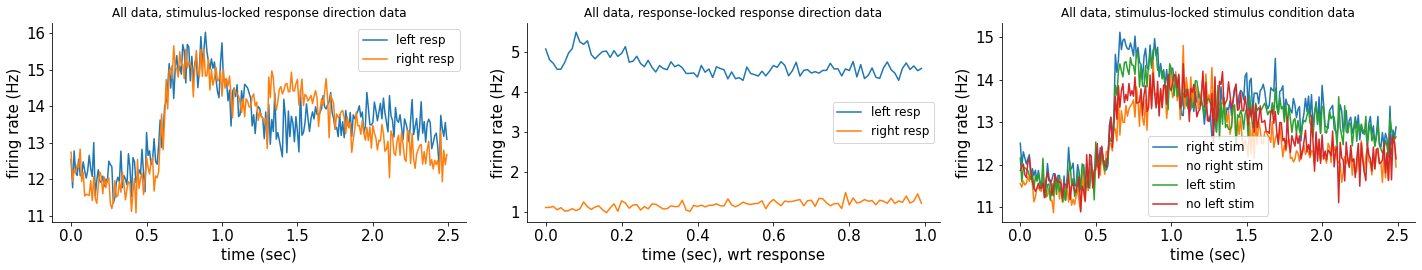

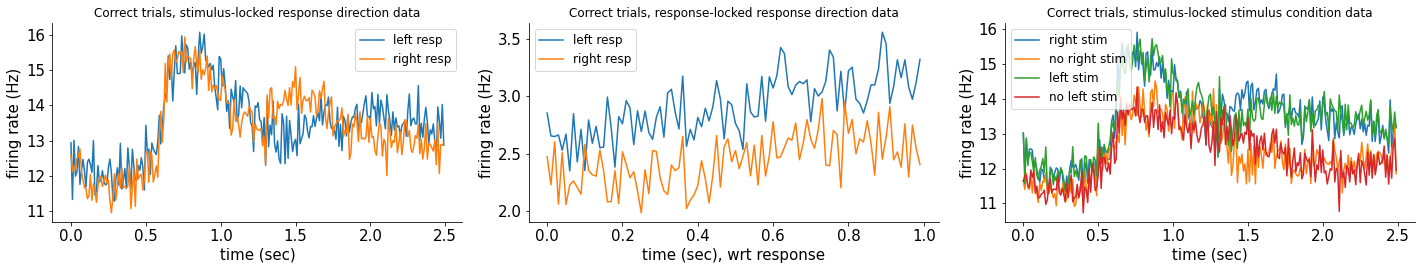

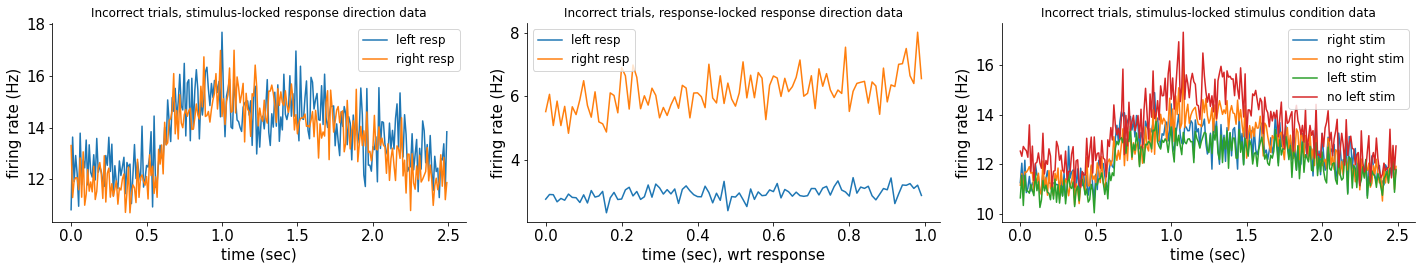

In [34]:
fig0, axes0 = plt.subplots(1,3,'none')
axes0[0].plot(dt * np.arange(NT), np.mean(ALLDATA_LEFTRESP[in_session,:],axis=0)) # left responses
axes0[0].plot(dt * np.arange(NT), np.mean(ALLDATA_RIGHTRESP[in_session,:],axis=0)) # right responses
axes0[0].legend(['left resp', 'right resp'], fontsize=12)
axes0[0].set_title('All data, stimulus-locked response direction data', fontsize=12)
axes0[0].set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');
axes0[1].plot(dt * np.arange(100), np.mean(ALLDATA_LEFTLOCKED[in_session,:],axis=0)) # left responses
axes0[1].plot(dt * np.arange(100), np.mean(ALLDATA_RIGHTLOCKED[in_session,:],axis=0)) # right responses
axes0[1].legend(['left resp', 'right resp'], fontsize=12)
axes0[1].set_title('All data, response-locked response direction data', fontsize=12)
axes0[1].set(xlabel  = 'time (sec), wrt response', ylabel = 'firing rate (Hz)');
axes0[2].plot(dt * np.arange(NT), np.mean(ALLDATA_RIGHTSTIM[in_session,:],axis=0)) # right stimuli
axes0[2].plot(dt * np.arange(NT), np.mean(ALLDATA_NORIGHTSTIM[in_session,:],axis=0)) # no right stimuli
axes0[2].plot(dt * np.arange(NT), np.mean(ALLDATA_LEFTSTIM[in_session,:],axis=0)) # left stimuli
axes0[2].plot(dt * np.arange(NT), np.mean(ALLDATA_NOLEFTSTIM[in_session,:],axis=0)) # no left stimuli
axes0[2].legend(['right stim','no right stim','left stim','no left stim'], fontsize=12)
axes0[2].set_title('All data, stimulus-locked stimulus condition data', fontsize=12)
axes0[2].set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

fig1, axes1 = plt.subplots(1,3,'none')
axes1[0].plot(dt * np.arange(NT), np.mean(ALLDATA_CORR_LEFTRESP[in_session,:],axis=0)) # left responses
axes1[0].plot(dt * np.arange(NT), np.mean(ALLDATA_CORR_RIGHTRESP[in_session,:],axis=0)) # right responses
axes1[0].legend(['left resp', 'right resp'], fontsize=12)
axes1[0].set_title('Correct trials, stimulus-locked response direction data', fontsize=12)
axes1[0].set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');
axes1[1].plot(dt * np.arange(100), np.mean(ALLDATA_CORR_LEFTLOCKED[in_session,:],axis=0)) # left responses
axes1[1].plot(dt * np.arange(100), np.mean(ALLDATA_CORR_RIGHTLOCKED[in_session,:],axis=0)) # right responses
axes1[1].legend(['left resp', 'right resp'], fontsize=12)
axes1[1].set_title('Correct trials, response-locked response direction data', fontsize=12)
axes1[1].set(xlabel  = 'time (sec), wrt response', ylabel = 'firing rate (Hz)');
axes1[2].plot(dt * np.arange(NT), np.mean(ALLDATA_CORR_RIGHTSTIM[in_session,:],axis=0)) # right stimuli
axes1[2].plot(dt * np.arange(NT), np.mean(ALLDATA_CORR_NORIGHTSTIM[in_session,:],axis=0)) # no right stimuli
axes1[2].plot(dt * np.arange(NT), np.mean(ALLDATA_CORR_LEFTSTIM[in_session,:],axis=0)) # left stimuli
axes1[2].plot(dt * np.arange(NT), np.mean(ALLDATA_CORR_NOLEFTSTIM[in_session,:],axis=0)) # no left stimuli
axes1[2].legend(['right stim','no right stim','left stim','no left stim'], fontsize=12)
axes1[2].set_title('Correct trials, stimulus-locked stimulus condition data', fontsize=12)
axes1[2].set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

fig2, axes2 = plt.subplots(1,3,'none')
axes2[0].plot(dt * np.arange(NT), np.mean(ALLDATA_INCORR_LEFTRESP[in_session,:],axis=0)) # left responses
axes2[0].plot(dt * np.arange(NT), np.mean(ALLDATA_INCORR_RIGHTRESP[in_session,:],axis=0)) # right responses
axes2[0].legend(['left resp', 'right resp'], fontsize=12)
axes2[0].set_title('Incorrect trials, stimulus-locked response direction data', fontsize=12)
axes2[0].set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');
axes2[1].plot(dt * np.arange(100), np.mean(ALLDATA_INCORR_LEFTLOCKED[in_session,:],axis=0)) # left responses
axes2[1].plot(dt * np.arange(100), np.mean(ALLDATA_INCORR_RIGHTLOCKED[in_session,:],axis=0)) # right responses
axes2[1].legend(['left resp', 'right resp'], fontsize=12)
axes2[1].set_title('Incorrect trials, response-locked response direction data', fontsize=12)
axes2[1].set(xlabel  = 'time (sec), wrt response', ylabel = 'firing rate (Hz)');
axes2[2].plot(dt * np.arange(NT), np.mean(ALLDATA_INCORR_RIGHTSTIM[in_session,:],axis=0)) # right stimuli
axes2[2].plot(dt * np.arange(NT), np.mean(ALLDATA_INCORR_NORIGHTSTIM[in_session,:],axis=0)) # no right stimuli
axes2[2].plot(dt * np.arange(NT), np.mean(ALLDATA_INCORR_LEFTSTIM[in_session,:],axis=0)) # left stimuli
axes2[2].plot(dt * np.arange(NT), np.mean(ALLDATA_INCORR_NOLEFTSTIM[in_session,:],axis=0)) # no left stimuli
axes2[2].legend(['right stim','no right stim','left stim','no left stim'], fontsize=12)
axes2[2].set_title('Incorrect trials, stimulus-locked stimulus condition data', fontsize=12)
axes2[2].set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');


# Function that takes session data and outputs indices of neurons to include. Excluded neurons include those with firing rates too far above/below the mean w/in regions.

In [9]:
def happy_neurons(session_data, brain_areas):
  """ 
    arguments:
    inputs:
    session_data: the data from one session (i.e., 3D data in alldat[asession]['spks'])
    brain_areas: array of the brain areas for each neuron in the session data
    
    output:
    neurons_to_use: a boolean array as long as the first dim of session data (the neuron 
    dimension). Values of True indicate neuron is the upper 60% of the firing count distribution
    for a given region. False indicates neuron is not responsive enough, falls below that threshold.
  """

  all_areas = np.unique(brain_areas)
  neurons_to_use = np.zeros(np.shape(session_data)[0],dtype=bool)
  region_quantile40 = np.zeros(len(all_areas))

  for iregion in range(len(all_areas)-1):
    region_data = session_data[brain_areas==all_areas[iregion],:,:]
    # get the value at quantile 40 of distribution (we will remove neurons below that threshold)
    spike_counts = np.sum(np.mean(region_data,axis=1),axis=1)
    ranked_neurons = np.sort(spike_counts)
    region_quantile40[iregion] = np.quantile(ranked_neurons,.40) # get value at 40th quantile for the region

  total_spikes = np.sum(np.mean(session_data,axis=1),axis=1)
  for ineuron in range(np.shape(session_data)[0]):
    region_its_in = np.where(brain_areas[ineuron]==all_areas)
    if total_spikes[ineuron] < region_quantile40[region_its_in] or total_spikes[ineuron] == 0 :
      neurons_to_use[ineuron] = False
    else:
      neurons_to_use[ineuron] = True

  return (neurons_to_use)

# example
dat = alldat[2]
neurons_to_use = happy_neurons(dat['spks'],dat['brain_area'])
print(neurons_to_use)

[False  True False False  True False False  True  True False  True False
  True  True False False  True  True False False  True  True  True False
  True  True False False False False  True  True False  True  True  True
  True  True False False False False  True False False  True  True  True
  True  True  True False False False  True False  True  True False False
  True  True False False False  True False False False  True  True  True
  True False  True False False False  True  True False False  True False
 False  True  True  True False  True  True False  True  True  True False
  True  True  True False False False  True  True False  True  True False
 False False False  True False False False  True False False False  True
  True  True  True  True  True  True  True False False False False  True
 False  True False  True False  True False False  True False False False
  True  True False False  True False  True  True False False  True  True
  True False  True False False False False  True  T